# Data preparation

In [304]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
# import lightgbm as lgb
# from sklearn.linear_model import LinearRegression
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.svm import SVR
# from xgboost import XGBRegressor
import seaborn as sns

## Set path to folder with data

In [305]:
folder_path = Path('full_data')
patients_info_path = Path('full_data/HUPA-data_patients/patients_info.csv')

## Load patients info and check duplicates

In [306]:
# Check folder and file existence
if not os.path.exists(folder_path):
    raise FileNotFoundError(f"Directory {folder_path} does not exist.")
if not os.path.exists(patients_info_path):
    raise FileNotFoundError(f"File {patients_info_path} does not exist.")

patients_info = pd.read_csv(patients_info_path)
if patients_info['person_id'].duplicated().any():
    raise ValueError("Duplicate person_id found in patients_info.csv!")
print("Unique person_ids in patients_info:", patients_info['person_id'].nunique())

patients_info.head(10)

Unique person_ids in patients_info: 25


,person_id,gender,HbA1c,age,dx_time,weight,height,treatment
0,HUPA0001P,female,8.2,56.3,15.5,59.0,161,CSII
1,HUPA0002P,male,7.1,48.6,36.5,82.4,186,CSII
2,HUPA0003P,male,7.3,43.4,12.5,62.0,182,CSII
3,HUPA0004P,male,7.8,41.2,8.5,88.0,180,CSII
4,HUPA0005P,female,6.9,41.9,39.5,58.5,161,CSII
5,HUPA0006P,male,7.8,22.1,13.5,71.0,170,CSII
6,HUPA0007P,male,6.6,37.6,10.1,102.6,183,CSII
7,HUPA0009P,female,7.6,41.2,30.7,64.0,165,CSII
8,HUPA0010P,female,6.0,41.9,15.2,51.0,164,CSII
9,HUPA0011P,female,7.8,35.0,27.3,56.0,153,CSII


In [307]:
patients_info.columns

Index(['person_id', 'gender', 'HbA1c', 'age', 'dx_time', 'weight', 'height',
       'treatment'],
      dtype='object')

In [308]:
patients_info.dtypes

person_id     object
gender        object
HbA1c        float64
age          float64
dx_time      float64
weight       float64
height         int64
treatment     object
dtype: object

In [309]:
patients_info.describe()

,HbA1c,age,dx_time,weight,height
count,25.000000,25.000000,25.000000,25.000000,25.000000
mean,7.368000,39.240000,17.816000,69.068000,169.040000
std,0.832026,12.081873,10.711041,14.420839,10.628107
min,6.000000,18.000000,0.800000,51.000000,153.000000
25%,6.900000,29.900000,11.200000,58.500000,161.000000
50%,7.200000,41.200000,15.200000,64.000000,167.000000
75%,7.800000,47.900000,24.200000,77.600000,179.000000
max,9.700000,61.800000,39.500000,104.800000,188.000000


<Figure size 1500x1500 with 0 Axes>

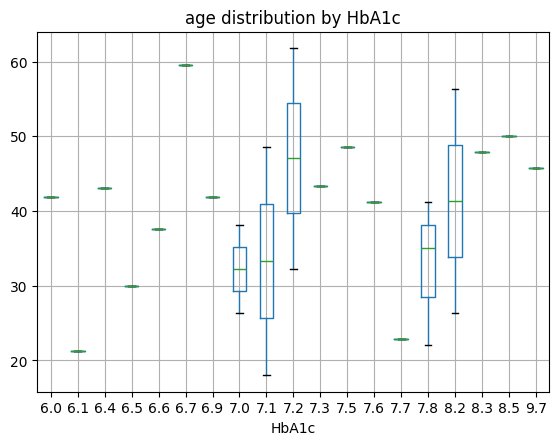

<Figure size 1500x1500 with 0 Axes>

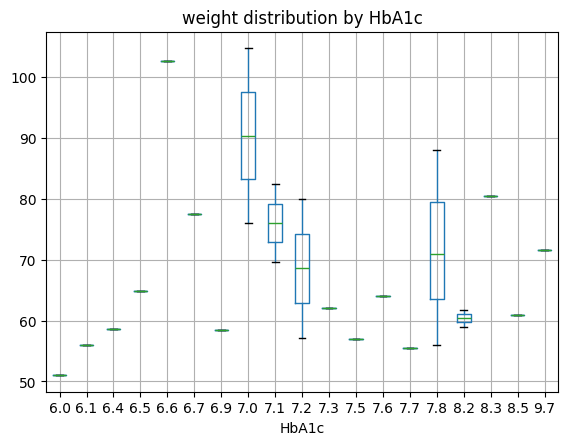

<Figure size 1500x1500 with 0 Axes>

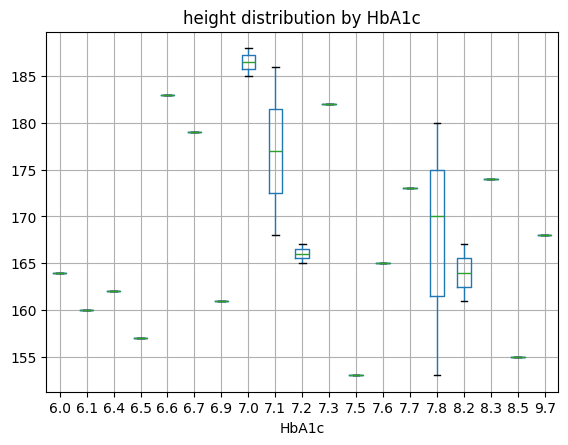

In [310]:
numerical_columns = ['age', 'weight', 'height']

for num_col in numerical_columns:
    plt.figure(figsize=(15, 15))
    patients_info.boxplot(by='HbA1c', column=num_col)
    plt.title(f'{num_col} distribution by HbA1c')
    plt.suptitle('')
    plt.show()

## Load time series data and combine and preprocess data

In [311]:
all_files = [folder_path / f for f in os.listdir(folder_path) if f.endswith('.csv')]
data_list = []
for file in all_files:
    temp_data = pd.read_csv(file, delimiter=';')
    temp_data['person_id'] = file.stem
    data_list.append(temp_data)

df = pd.concat(data_list, ignore_index=True).drop_duplicates()

## Convert time and handle errors

In [312]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.dropna(subset=['time'])
df['minute'] = df['time'].dt.minute
df['hour_of_day'] = df['time'].dt.hour
df['month'] = df['time'].dt.month
# df['year'] = df['time'].dt.year
df['day'] = df['time'].dt.day.clip(1, df['time'].dt.days_in_month)
df.columns
# df.to_csv('data_processed/combined_patientID_data.csv', index=False, sep=',')
# print('Combined HUPA-UCM-full_data was saved as combined_data.csv')

Index(['time', 'glucose', 'calories', 'heart_rate', 'steps', 'basal_rate',
       'bolus_volume_delivered', 'carb_input', 'person_id', 'minute',
       'hour_of_day', 'month', 'day'],
      dtype='object')

## Fill missing values safely

In [313]:
for col in ['glucose', 'calories', 'heart_rate']:
    if df[col].isna().all():
        df[col] = 0
    else:
        df[col] = df[col].fillna(df[col].mean())
df = df.fillna(0)

# Merge with patients_info
df = df.merge(patients_info, on='person_id', how='left')

## Anomaly checks

In [314]:
# Heart rate check
df = df[(df['heart_rate'] > 40) & (df['heart_rate'] < 200)]
# Glucose range check
df = df[(df['glucose'] >= 0) & (df['glucose'] <= 500)]
# Minute range check
df = df[(df['minute'] >= 0) & (df['minute'] <= 59)]
# Hour of day range check
df = df[(df['hour_of_day'] >= 0) & (df['hour_of_day'] <= 23)]
# Month range check
df = df[(df['month'] >= 1) & (df['month'] <= 12)]
# Age range check
df = df[(df['age'] >= 0) & (df['age'] <= 120)]
# Weight range check
df = df[(df['weight'] >= 30) & (df['weight'] <= 300)]
# Height range check
df = df[(df['height'] >= 50) & (df['height'] <= 250)]

## Create output directory

In [315]:
os.makedirs('data_processed', exist_ok=True)

## Save processed data

In [316]:
# HUPA-UCM-full_data.to_csv('data_processed/prepared_data_with_patient_info.csv', index=False)
# print('Data saved successfully.')

## Check target variable

In [317]:
if df['basal_rate'].isna().any():
    raise ValueError("Target variable 'basal_rate' contains missing values!")

## One-Hot Encoding

In [318]:
df = pd.get_dummies(df, columns=['gender', 'treatment'], drop_first=True)

## Analyse of data

In [319]:
df.head(8)

,time,glucose,calories,heart_rate,steps,basal_rate,bolus_volume_delivered,carb_input,person_id,minute,hour_of_day,month,day,HbA1c,age,dx_time,weight,height,gender_male,treatment_MDI
0,2018-09-19 14:25:00,90.041667,14.551950,70.521127,77.0,0.066667,0.0,0.0,HUPA0007P,25,14,9,19,6.6,37.6,10.1,102.6,183,True,False
1,2018-09-19 14:30:00,85.750000,17.323750,78.504202,62.0,0.066667,0.0,0.0,HUPA0007P,30,14,9,19,6.6,37.6,10.1,102.6,183,True,False
2,2018-09-19 14:35:00,81.458333,12.888870,73.060345,16.0,0.066667,0.0,0.0,HUPA0007P,35,14,9,19,6.6,37.6,10.1,102.6,183,True,False
3,2018-09-19 14:40:00,77.166667,16.769390,67.981481,79.0,0.066667,0.0,0.0,HUPA0007P,40,14,9,19,6.6,37.6,10.1,102.6,183,True,False
4,2018-09-19 14:45:00,72.875000,42.131361,92.503356,444.0,0.066667,0.0,0.0,HUPA0007P,45,14,9,19,6.6,37.6,10.1,102.6,183,True,False
5,2018-09-19 14:50:00,68.583333,49.060859,109.291667,459.0,0.066667,0.0,0.0,HUPA0007P,50,14,9,19,6.6,37.6,10.1,102.6,183,True,False
6,2018-09-19 14:55:00,64.291667,44.071620,101.888889,435.0,0.066667,0.0,0.0,HUPA0007P,55,14,9,19,6.6,37.6,10.1,102.6,183,True,False
7,2018-09-19 15:00:00,60.000000,14.136180,95.834711,9.0,0.066667,0.0,0.0,HUPA0007P,0,15,9,19,6.6,37.6,10.1,102.6,183,True,False


<Axes: >

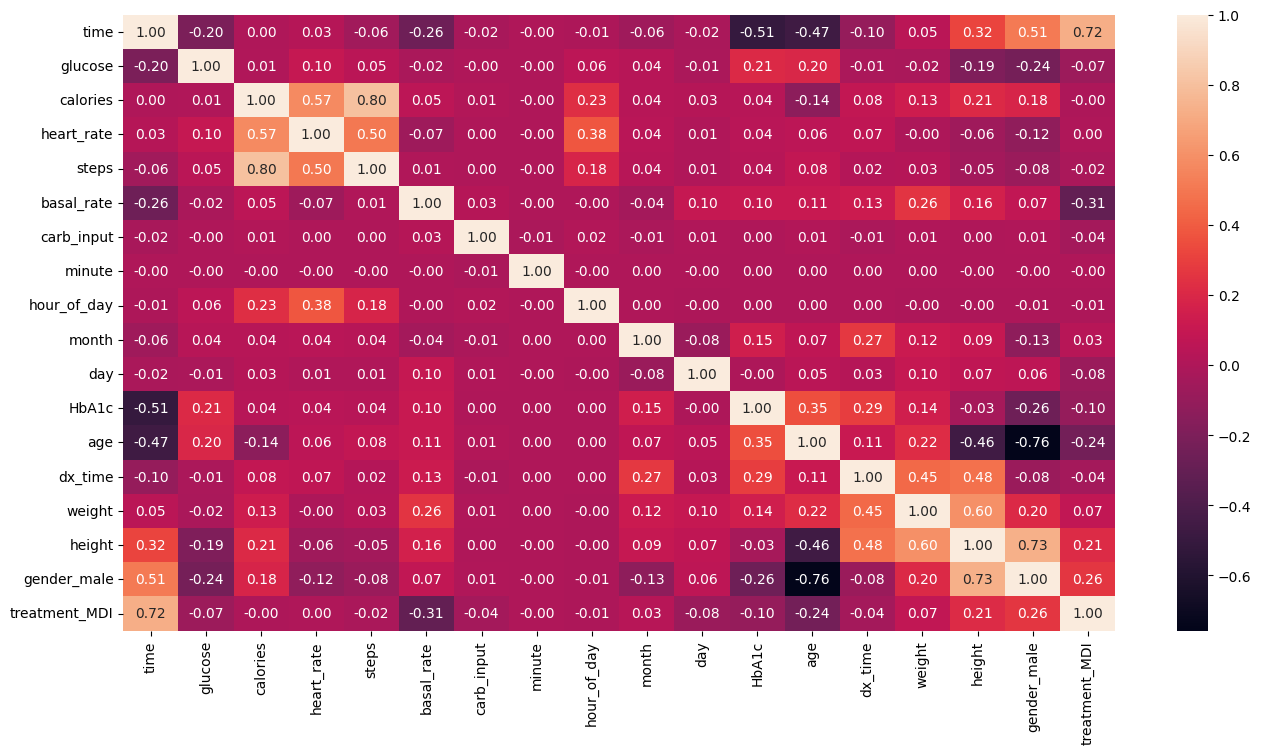

In [320]:
plt.figure(figsize=(16,8))
sns.heatmap(df.drop(columns=['bolus_volume_delivered', 'person_id']).corr(), annot=True, fmt='.2f')

## Define features

In [321]:
features = [
    'glucose', 'calories', 'heart_rate', 'steps',
    'bolus_volume_delivered', 'carb_input', 'minute',
    'hour_of_day', 'month', 'day', 'HbA1c', 'age',
    'dx_time', 'weight', 'height'
]
features += [col for col in df.columns if col.startswith(('gender_', 'treatment_'))]
print(features)

['glucose', 'calories', 'heart_rate', 'steps', 'bolus_volume_delivered', 'carb_input', 'minute', 'hour_of_day', 'month', 'day', 'HbA1c', 'age', 'dx_time', 'weight', 'height', 'gender_male', 'treatment_MDI']


## Save data after adding One-Hot Encoding columns

In [322]:
# HUPA-UCM-full_data.to_csv('data_processed/final_prepared_data.csv', index=False, sep=',')
# print('Final prepared HUPA-UCM-full_data was saved as final_prepared_data.csv')


In [323]:
X = df[features]
y = df['basal_rate']

## Now calculating summary statistics for each of the columns

In [324]:
summary = df[features].describe().transpose()

## Saving summary statistics to CSV

In [325]:
# summary.to_csv('data_processed/summary_statistics.csv', sep=',')
# print('Summary statistics saved as summary_statistics.csv')

# Predict dose

In [326]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data scaling

In [327]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### DT model creation, training and evaluation

In [328]:
model = DecisionTreeRegressor(max_depth=22, min_samples_leaf=2, min_samples_split=2, random_state=42)
model.fit(X_train_scaled, y_train)
# Prediction and model evaluation
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

mse_rounded = round(mse, 6)
r2_rounded = round(r2, 6)
mae_rounded = round(mae, 6)

# Output results
print(f'Decision Tree. Mean Squared Error: {mse_rounded}')
print(f'Decision Tree. R²: {r2_rounded}')
print(f'Decision Tree. Mean Absolute Error: {mae_rounded}')

Decision Tree. Mean Squared Error: 0.000169
Decision Tree. R²: 0.870273
Decision Tree. Mean Absolute Error: 0.003959


### KNN model creation and training with feature selection (max_features)

In [329]:
# model = KNeighborsRegressor(weights='distance', n_neighbors=7, metric='manhattan')
# model.fit(X_train_scaled, y_train)
#
# # Prediction and model evaluation
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# mse_rounded = round(mse, 6)
# r2_rounded = round(r2, 6)
# mae_rounded = round(mae, 6)
#
# # Output results
# print(f'KNN. Mean Squared Error: {mse_rounded}')
# print(f'KNN. R²: {r2_rounded}')
# print(f'KNN. Mean Absolute Error: {mae_rounded}')

### LightGBM model creation and training

In [330]:
# model = lgb.LGBMRegressor(n_estimators=800, subsample=1.0, reg_lambda=1, reg_alpha=0.1, max_depth=14, learning_rate=0.05,
#                               num_leaves=31, colsample_bytree=0.6)
# model.fit(X_train_scaled, y_train)
#
# # Prediction and model evaluation
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# mse_rounded = round(mse, 6)
# r2_rounded = round(r2, 6)
# mae_rounded = round(mae, 6)
#
# # Output results
# print(f'LightGBM. Mean Squared Error: {mse_rounded}')
# print(f'LightGBM. R²: {r2_rounded}')
# print(f'LightGBM. Mean Absolute Error: {mae_rounded}')

### LR model creation and training

In [331]:
# model = LinearRegression()
# model.fit(X_train_scaled, y_train)
#
# # Prediction and model evaluation
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# mse_rounded = round(mse, 6)
# r2_rounded = round(r2, 6)
# mae_rounded = round(mae, 6)
#
# # Output results
# print(f'Linear Regression. Mean Squared Error: {mse_rounded}')
# print(f'Linear Regression. R²: {r2_rounded}')
# print(f'Linear Regression. Mean Absolute Error: {mae_rounded}')

### RF model creation and training

In [332]:
# model = RandomForestRegressor(n_estimators=200, min_samples_split=2, min_samples_leaf=1, random_state=42)
# model.fit(X_train_scaled, y_train)
#
# # Prediction and model evaluation
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# mse_rounded = round(mse, 6)
# r2_rounded = round(r2, 6)
# mae_rounded = round(mae, 6)
#
# # Output results
# print(f'Random Forest. Mean Squared Error: {mse_rounded}')
# print(f'Random Forest. R²: {r2_rounded}')
# print(f'Random Forest. Mean Absolute Error: {mae_rounded}')

### SVM model creation and training

In [333]:
# model = SVR(kernel='linear', C=1, gamma='scale') # it takes a long time to train
# model.fit(X_train_scaled, y_train)
#
# # Prediction and model evaluation
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# mse_rounded = round(mse, 6)
# r2_rounded = round(r2, 6)
# mae_rounded = round(mae, 6)
#
# # Output results
# print(f'Support Vector Regression. Mean Squared Error: {mse_rounded}')
# print(f'Support Vector Regression. R²: {r2_rounded}')
# print(f'Support Vector Regression. Mean Absolute Error: {mae_rounded}')

### XGBoost model creation and training

In [334]:
# model = XGBRegressor(n_estimators=800, subsample=1.0, reg_lambda=1, reg_alpha=0.1, max_depth=14, learning_rate=0.05,
#                          gamma=0, colsample_bytree=0.6)
# model.fit(X_train_scaled, y_train)
#
# # Prediction and model evaluation
# y_pred = model.predict(X_test_scaled)
#
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
#
# mse_rounded = round(mse, 6)
# r2_rounded = round(r2, 6)
# mae_rounded = round(mae, 6)
#
# # Output results
# print(f'XGBRegressor. Mean Squared Error: {mse_rounded}')
# print(f'XGBRegressor. R²: {r2_rounded}')
# print(f'XGBRegressor. Mean Absolute Error: {mae_rounded}')